### Name: Chuchen Xiong
### Email: xion2022@umn.edu

# Table of Contents <a class='anchor' id='toc'></a>

#### I. [Data Preprocessing](#dp)
#### II. [Question A](#qa)
#### III. [Question B](#qb)
#### IV. [Question C](#qc)
#### V. [Question D](#qd)
#### VI. [Question E](#qe)

# Data Preprocessing <a class="anchor" id="dp"></a>
**[Back to top](#toc)**

### Import packages and load data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
# Import packages
import pandas as pd
from scipy import stats
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Import the data
df = pd.read_csv('C:/Users/sysux/Desktop/screening_exercise_orders_v201810.csv')

In [4]:
# Display first five rows
df.head()

,customer_id,gender,date,value,predicted_gender
0,1000,0,2017-01-01 00:11:31,198.5,1
1,1001,0,2017-01-01 00:29:56,338.0,1
2,1002,1,2017-01-01 01:30:31,733.0,1
3,1003,1,2017-01-01 01:34:22,772.0,1
4,1004,0,2017-01-01 03:11:54,508.0,1


In [5]:
# Display data shape. This dataset has five columns and 13471 rows.
df.shape

(13471, 5)

### Check Data Type

In [6]:
# Display data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471 entries, 0 to 13470
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       13471 non-null  int64  
 1   gender            13471 non-null  int64  
 2   date              13471 non-null  object 
 3   value             13471 non-null  float64
 4   predicted_gender  13471 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 526.3+ KB


The dataset does not have missing value. However, I find that date column is string type, we need to convert it to datetime type. Also customer_id needs to be the string type.

In [7]:
# Convert date type
df['date'] = pd.to_datetime(df['date'])
df['customer_id'] = df['customer_id'].astype('str')

### Check duplicate rows

In [8]:
# Check duplicates
df[df.duplicated()]

,customer_id,gender,date,value,predicted_gender
9961,7401,0,2017-09-21 22:58:02,1336.00,0
10775,8056,1,2017-10-10 03:35:53,462.57,1


As we can see, there are two duplicate rows with all data is the same. It is unlikely for a customer purchases same amount of money at the same time. I assume that technical issues cause these duplicates. Therefore, I remove these two rows.

In [9]:
# Drop duplicates
df = df.drop_duplicates()

### Exploratory Analysis

Gender and predicted_gender have two unique values. 

In [10]:
# Number of unique values in each column
for col in df:
    print('%s column has %d unique values' % (col, len(df[col].unique())))

customer_id column has 8814 unique values
gender column has 2 unique values
date column has 13461 unique values
value column has 4079 unique values
predicted_gender column has 2 unique values


In [11]:
# Descriptive statistics
df.describe()

,gender,value,predicted_gender
count,13469.000000,13469.000000,13469.000000
mean,0.498255,357.241703,0.642809
std,0.500016,387.146663,0.479189
min,0.000000,0.000000,0.000000
25%,0.000000,161.200000,0.000000
50%,0.000000,258.000000,1.000000
75%,1.000000,426.000000,1.000000
max,1.000000,8046.300000,1.000000


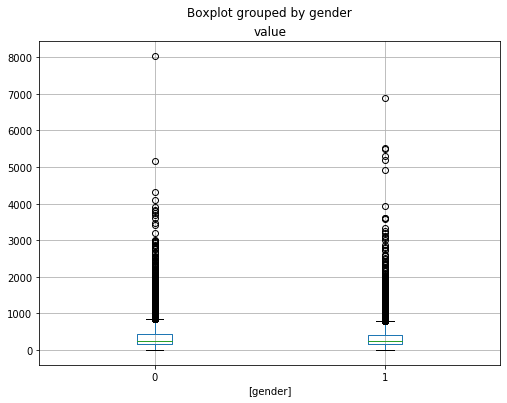

In [12]:
# Distribution of value
df.boxplot(column=['value'], by = ['gender'], figsize=(8,6))

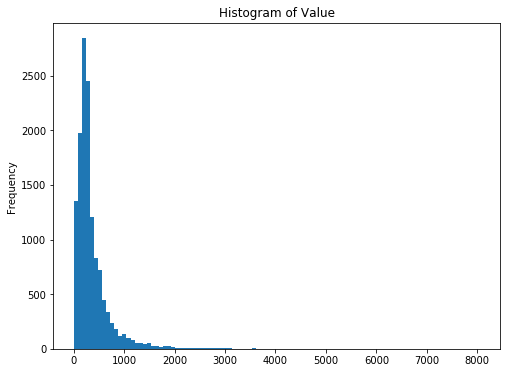

In [13]:
# Distribution of value
df['value'].plot(kind='hist', title='Histogram of Value', bins=100,  figsize=(8,6))

In [14]:
# Check large values by sorting by value descending
df.sort_values('value', ascending = False).head()

,customer_id,gender,date,value,predicted_gender
11074,8217,0,2017-10-22 14:11:25,8046.3,1
9642,7379,1,2017-09-11 20:17:19,6877.0,1
10989,1145,1,2017-10-18 19:06:48,5530.0,1
3086,3393,1,2017-03-24 17:10:18,5480.0,1
10901,8124,1,2017-10-15 21:54:10,5300.2,0


In the distribution of value column, there are several large values such as 8046.3 and 6877.0. Since they fall into reasonable range and we don't have reasons to define them as anomalies, I decide to keep them.

# Question A <a class="anchor" id="qa"></a>
**[Back to top](#toc)**

Assemble a dataframe with one row per customer and the following columns:

* customer_id
* gender
* most_recent_order_date
* order_count (number of orders placed by this customer)

Sort the dataframe by customer_id ascending and display the first 10 rows.

In [15]:
# Group by customer_id and gender to get most recent order date and order count
df_custmoer = df.groupby(['customer_id', 'gender']).agg({'date': 'max', 'value': 'count'}) \
                                                   .reset_index() \
                                                   .rename(columns={'date':'most_recent_order_date',
                                                                   'value':'order_count'})
# Sort by customer_id ascending
df_custmoer = df_custmoer.sort_values('customer_id', ascending = True)
# Display the first 10 rows
df_custmoer.head(10)

,customer_id,gender,most_recent_order_date,order_count
0,1000,0,2017-01-01 00:11:31,1
1,1001,0,2017-01-01 00:29:56,1
2,1002,1,2017-02-19 21:35:31,3
3,1003,1,2017-04-26 02:37:20,4
4,1004,0,2017-01-01 03:11:54,1
5,1005,1,2017-12-16 01:39:27,2
6,1006,1,2017-05-09 15:27:20,3
7,1007,0,2017-01-01 15:59:50,1
8,1008,0,2017-12-17 05:47:48,3
9,1009,1,2017-01-01 19:27:17,1


# Question B <a class="anchor" id="qb"></a>
**[Back to top](#toc)**

Plot the count of orders per week for the store.

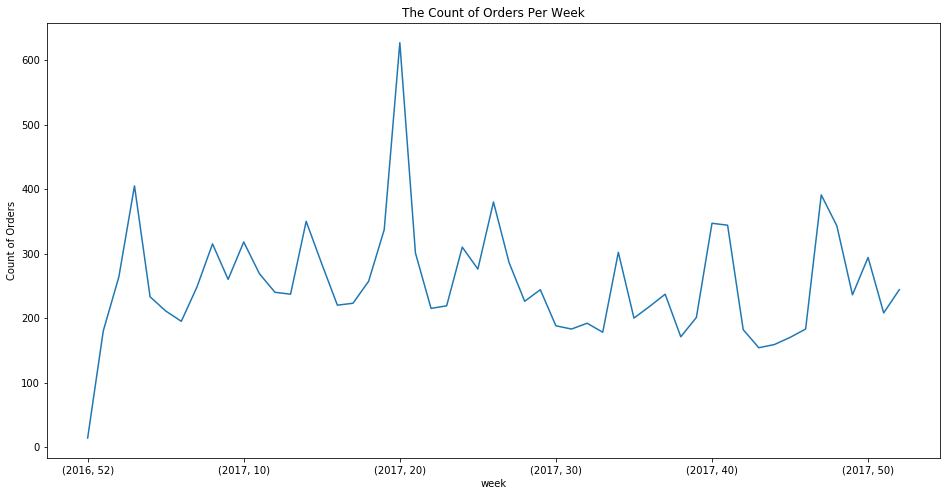

In [16]:
# I use the calender week (from Monday to Sunday). Since 1/1/2017 is Sunday, the first week only has one day.
# Group by each 7 days
df_week = df.copy()
df_week['week'] = df_week.date.map(lambda x: pd.to_datetime(x).isocalendar()[:2])
plt = df_week.groupby('week').size().plot(title='The Count of Orders Per Week',
                                                               figsize=(16,8))
plt = plt.set_ylabel("Count of Orders")

# Question C <a class="anchor" id="qc"></a>
**[Back to top](#toc)**

Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant? Justify your choice of method.

In [17]:
# Compute the mean order value for gender 0 and for gender 1
df_gender = df.groupby('gender').mean()['value']
print('The mean order value for gender 0 is', round(df_gender[0],2))
print('The mean order value for gender 1 is', round(df_gender[1],2))

The mean order value for gender 0 is 363.75
The mean order value for gender 1 is 350.69


Some assumption for this dataset:

1. The data is collected from a representative, randomly selected portion of the total population.
2. Each transaction is independent.

We want to use t-test to find the significant difference in these two groups. Here we also need to check data to make sure it result in a normal distribution, bell-shaped distribution curve.

#### Check normalization

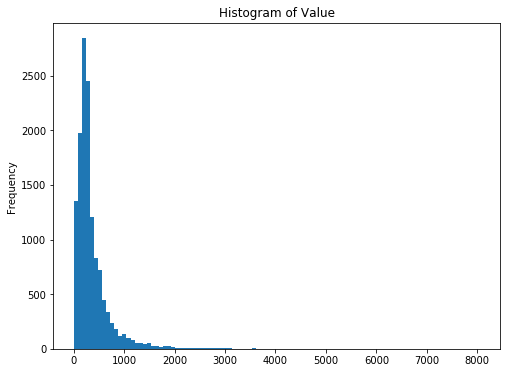

In [18]:
# Histogram
df['value'].plot(kind='hist', title='Histogram of Value', bins=100,  figsize=(8,6))

The data does not fall into a bell-shaped distribution.

Let's look at the Q-Q Plot. QQ Plot stands for Quantile vs Quantile Plot, which is exactly what it does: plotting theoretical quantiles against the actual quantiles of our variable.

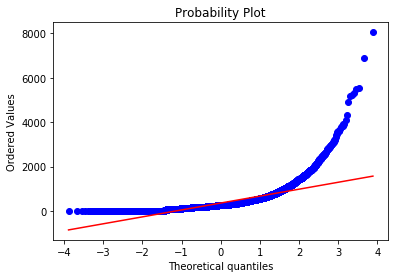

In [19]:
# Q-Q plot
stats.probplot(df['value'], dist="norm", plot=pylab)
pylab.show()

The points on a normal QQ Plot deviate strongly from the straight line. This distribution has too many observations in both extremities (very high and very low values).

Let's look at the Kolmogorov Smirnov test. (Since the sample size is too large, it should be cautious to use this test.) The Kolmogorov Smirnov test computes the distances between the empirical distribution and the theoretical distribution and defines the test statistic as the supremum of the set of those distances.

In [20]:
# Shapiro-Wilk normality test
ks_statistic, p_value = stats.kstest(df['value'], 'norm')
print('Statistics=%.3f, p=%.3f' % (ks_statistic, p_value))

Statistics=0.996, p=0.000


The P-Value of the KS Test is smaller than 0.05, we do not assume a normal distribution

**In conclusion, we don't assume that the value comes from a normal distribution so we cannot use a t-test.**

We need to use How to the Mann-Whitney U test instead. The Mann-Whitney U test is a nonparametric statistical significance test for determining whether two independent samples were drawn from a population with the same distribution.

Null Hypothesis: The value of these two groups are drawn from the same population, thus there is no significant difference.

Alternative Hypothesis: The value of these two groups are drawn from different population, thus there is a significant difference.

In [21]:
# Get data from two groups
gender_0 = df[df['gender'] == 0]['value']
gender_1 = df[df['gender'] == 1]['value']

stat, p = stats.mannwhitneyu(gender_0, gender_1)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=22446069.500, p=0.154


Since the P-value is 0.154, if our chosen significance level is 0.05, we don't have a strong evidence to reject the null hypothesis. Therefore, there is no significant different of these two groups.

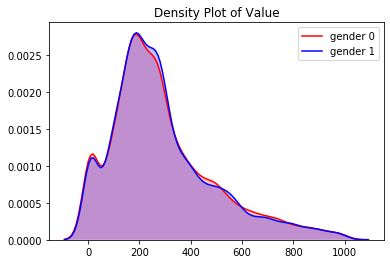

In [28]:
# Density plot
p=sns.kdeplot(df[df['gender']==0][df['value']<=1000]['value'].rename('gender 0'), shade=True, color="r", legend='gender0')
p=sns.kdeplot(df[df['gender']==1][df['value']<=1000]['value'].rename('gender 1'), shade=True, color="b", legend='gender1')
p.set_title("Density Plot of Value")
plt.show()

To verify the conclusion, we use the density plot to check there is indeed no significant between these two groups.

# Question D <a class="anchor" id="qd"></a>
**[Back to top](#toc)**

Generate a confusion matrix for the gender predictions of customers in this dataset. You can assume that there is only one gender prediction for each customer. What does the confusion matrix tell you about the quality of the predictions?

              precision    recall  f1-score   support

           0       0.70      0.50      0.58      6758
           1       0.61      0.78      0.68      6711

    accuracy                           0.64     13469
   macro avg       0.65      0.64      0.63     13469
weighted avg       0.65      0.64      0.63     13469



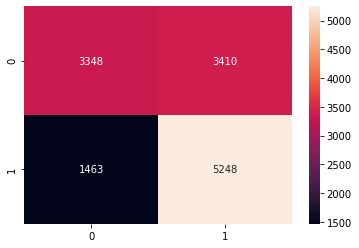

In [29]:
# Visualize the confusion matrix
cm = confusion_matrix(df['gender'],df['predicted_gender'])
sns.heatmap(cm,annot=True,fmt="d")

# Print the classification result
print(classification_report(df['gender'],df['predicted_gender']))

Here are four number in the confusion matrix above:

True Positive (3348) : Ground truth is positive and is predicted to be positive.

False Negative (3410) : Ground truth is positive but is predicted to be negative.

True Negative (5248) : Ground truth is negative and is predicted to be negative.

False Positive (1463) : Ground truth is negative but is predicted to be positive.
   
The precision for gender 0 is 0.70 and for gender 1 is 0.61. The recall for gender 0 is 0.50 and for gender 1 is 0.78
   
For gender 0, we miss a lot of positive examples but those we predict as positive are indeed positive.

For gender 1, we capture a lot of positive examples but some of those we predict as positive are actually negative.

Generally, we can use precision and recall to compute a new metric - F1 score, which equals to 2 * (precision * recall) / (precision + recall). We do not focus on much whereas False Negative and False Positive usually has business costs (tangible & intangible) thus F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall. From the result, F1 Score for gender 0 is 0.58 and for gender 1 is 0.68.

# Question E <a class="anchor" id="qe"></a>
**[Back to top](#toc)**

Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a problem. Limit your answer to one paragraph, and please be specific.

My favorite tool for data science is the Scikit-Learn package in Python. 
This package enables us to build machine learning pipelines including data cleaning, feature selection, cross validation, and model evaluation. I would share a fraud detection project I did in Kaggle. I performed data cleaning such as missing values imputation and normalization. Then, I selected important features from 200+ columns by using Random Forest. The next step was to setting up a pipeline and conducting hyperparameter tuning and cross validation to compare different models such as Random Forest, XGBoost, and LightGBM. I also used this package to stacked basic models such as KNN, SVM, and decision trees with XGBoost, which can increase the accuracy. Scikit-Learn also provides us with multiple evaluation metrics such as Confusion Matrix and ROC. We can see the performance of each model visually. In conclusion, Scikit-Learn is very useful to help me solve problems related to machine learning with its supervised and unsupervised built-in models.